In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm


import torchvision
import torchvision.transforms as transforms

sys.path.append('../')
from models.vit import *

/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [3]:
epochs = 90
batch_size = 64
momentum = 0.9
lr = 0.00005
weight_decay = 1e-4
img_size = 32
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_workers = os.cpu_count()
saved = '../saved/cifar_net_32_s2.pth'

In [4]:
train_transforms = transforms.Compose([
                    transforms.ColorJitter(0.1,0.1,0.1,0.1),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomResizedCrop(img_size, scale=(0.5, 1.0), ratio=(0.75, 1.25)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [5]:
train_dataset = torchvision.datasets.CIFAR10('../dataset', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10('../dataset', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
images, targets = next(iter(train_loader))
images.shape, targets

(torch.Size([64, 3, 32, 32]),
 tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
         2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
         2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7]))

In [8]:
model_args = dict(img_size=img_size, 
                  patch_size=8, 
                  embed_dim=192, 
                  depth=12, 
                  num_heads=2, 
                  checkpoint='', 
                  qk_norm=True, 
                  v_norm=True, 
                  patch_stride=2)
model =  vit_small_patch8_32(**model_args)

In [9]:
out = model(images)
out.shape

torch.Size([64, 10])

In [10]:
# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    

In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


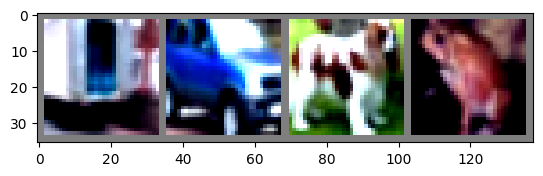

In [13]:
imshow(torchvision.utils.make_grid(images[:4]))

In [14]:

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, )
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=5, 
#                                         step_size_down=None, mode='exp_range', gamma=0.995)
from utils.scheduler import CosineAnnealingWarmUpRestarts
scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=0.1,  T_up=5, gamma=0.2)

model = model.to(device)

In [15]:
from utils.train import get_acc

In [16]:
best_acc = 0.
val_acc_list = []
for epoch in (range(epochs)):
    running_loss = []
    model.train()
    for i, data in (enumerate(train_loader)):
        images, targets = data
        images, targets = images.to(device), targets.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    test_acc = get_acc(test_loader, model, device)
    val_acc_list.append(test_acc)
    if best_acc < test_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), saved)

    lr = optimizer.param_groups[0]['lr']
    print(f'{epoch + 1} loss: {sum(running_loss)/len(running_loss):.3f} acc: {test_acc:.2f} lr: {lr:.5f}')
    if scheduler :
        scheduler.step()


1 loss: 1.961 acc: 37.08 lr: 0.00005
2 loss: 1.670 acc: 48.40 lr: 0.02004
3 loss: 1.420 acc: 54.22 lr: 0.04003
4 loss: 1.315 acc: 56.13 lr: 0.06002
5 loss: 1.235 acc: 54.43 lr: 0.08001
6 loss: 1.173 acc: 56.71 lr: 0.10000
7 loss: 1.095 acc: 60.75 lr: 0.09961
8 loss: 1.035 acc: 61.48 lr: 0.09843
9 loss: 0.992 acc: 63.80 lr: 0.09649
10 loss: 0.938 acc: 69.18 lr: 0.09382
11 loss: 0.906 acc: 67.89 lr: 0.09046
12 loss: 0.856 acc: 69.40 lr: 0.08646
13 loss: 0.829 acc: 71.22 lr: 0.08188
14 loss: 0.796 acc: 71.19 lr: 0.07680
15 loss: 0.761 acc: 72.53 lr: 0.07130
16 loss: 0.732 acc: 71.69 lr: 0.06547
17 loss: 0.697 acc: 73.54 lr: 0.05939
18 loss: 0.670 acc: 73.37 lr: 0.05316
19 loss: 0.639 acc: 74.64 lr: 0.04689
20 loss: 0.603 acc: 75.21 lr: 0.04066
21 loss: 0.576 acc: 76.26 lr: 0.03458
22 loss: 0.548 acc: 76.78 lr: 0.02875
23 loss: 0.518 acc: 77.79 lr: 0.02325
24 loss: 0.490 acc: 77.37 lr: 0.01817
25 loss: 0.462 acc: 78.35 lr: 0.01359
26 loss: 0.441 acc: 78.65 lr: 0.00959
27 loss: 0.419 acc: 7

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f0fe7a23280>
Traceback (most recent call last):
  File "/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/selectors.py", line 415, in se

KeyboardInterrupt: 

In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,5]
plt.plot(val_acc_list, label='val_acc')
plt.legend()


In [ ]:
from utils.train import get_all_preds
test_preds = get_all_preds(model.to('cpu'), test_loader)
actual_labels = torch.Tensor(test_dataset.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

In [ ]:
from utils.visualize import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes)